# Comparison between Ada-BKB (and variants) with state-of-art BO algorithms

In [46]:
import numpy as np
from adabkb.optimizer import AdaBKB
from adabkb.kernels import GaussianKernel
from adabkb.options import OptimizerOptions
import matplotlib.pyplot as plt
from cmaes import CMA
from adabkb.benchmark_functions import Branin, Rosenbrock

from scipy.optimize import minimize

def get_creg(X, fun):
    return np.cumsum([ fun(x) - fun(fun.global_min[0][0]) for x in X])



rnd_state = np.random.RandomState(12)

## Branin function

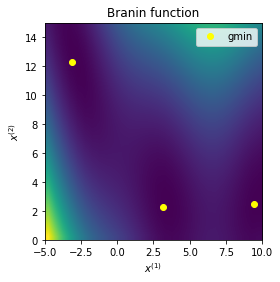

In [2]:
noise_params = (0.1, rnd_state)
branin_fun = Branin(noise_params=noise_params)
branin_fun_nonoise = Branin()

branin_fun_nonoise(branin_fun.global_min[0][0])

delta = 0.5

x = np.arange(branin_fun.search_space[0,0], branin_fun.search_space[0,1], delta)
y = np.arange(branin_fun.search_space[1,0], branin_fun.search_space[1,1], delta)
X, Y = np.meshgrid(x, y)


Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        Z[i,j] =  branin_fun_nonoise(np.array([X[i,j],Y[i,j]]).reshape(-1))





fig, ax = plt.subplots()
ax.set_xlim([branin_fun.search_space[0,0], branin_fun.search_space[0,1]])
ax.set_ylim([branin_fun.search_space[1,0], branin_fun.search_space[1,1]])
ax.set_title('Branin function')
ax.imshow(Z, interpolation ='bilinear',
               origin ='lower',
               cmap ="viridis", 
               extent =(branin_fun.search_space[0,0], branin_fun.search_space[0,1],branin_fun.search_space[1,0], branin_fun.search_space[1,1]))
ax.set_xlabel("$x^{(1)}$")
ax.set_ylabel("$x^{(2)}$")

gmin = np.array(branin_fun_nonoise.global_min[0]).reshape(-1, 2)


ax.plot(gmin[:, 0], gmin[:,1], 'o', c="yellow", label="gmin")
ax.legend(loc="best")


### AdaBKB

In [57]:
sigma = 2.0
lam = 1e-7
N = 3
delta = 1e-5
F = 1.0
hmax = 7

v_1 = N * np.sqrt(2)
rho = N**(-1/2)

kernel = GaussianKernel(sigma)
options = OptimizerOptions(kernel, v_1=v_1, rho=rho, lam=lam, sigma=sigma, delta=delta, fnorm=F)

optimizer = AdaBKB(options=options)

optimizer.initialize(branin_fun.search_space, N, h_max=hmax)

t = 0
T = 100

adabkb_regret = []

while t <= T:
    xt, idx = optimizer.step()
    yt = -branin_fun(xt)
    adabkb_regret.append(branin_fun_nonoise(xt) - branin_fun_nonoise(branin_fun_nonoise.global_min[0][0]))
    optimizer.update_model(idx, yt)
    t+=1

adabkb_regret = np.cumsum(adabkb_regret)




### L-CMA-ES

In [4]:
popsize = 4

mu = branin_fun_nonoise.search_space.mean(1)
sig = branin_fun_nonoise.search_space.std()

cma = CMA(mu, sig, bounds=branin_fun_nonoise.search_space, population_size=popsize, seed=12 )

t = 0
T = 100

lcmaes_regret = []
while t<= T:
    solutions = []
    for _ in range(cma.population_size):
        xt = cma.ask()
        value = branin_fun(xt)
        solutions.append((xt, value))
       # print(f"#{t} {value} (x1={xt[0]}, x2 = {xt[1]})")
        lcmaes_regret.append(branin_fun_nonoise(xt) - branin_fun_nonoise(branin_fun_nonoise.global_min[0][0]))
        t+=1

    cma.tell(solutions)
lcmaes_regret = np.cumsum(lcmaes_regret)


### Turbo

In [5]:
from turbo import Turbo1

turbo = Turbo1(
    f=branin_fun,  # Handle to objective function
    lb=branin_fun.search_space[:, 0],  # Numpy array specifying lower bounds
    ub=branin_fun.search_space[:, 1],  # Numpy array specifying upper bounds
    n_init=5,  # Number of initial bounds from an Latin hypercube design
    max_evals = T,  # Maximum number of evaluations
    batch_size= 1,  # How large batch size TuRBO uses
    verbose=False,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=30,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)


turbo.optimize()



X = turbo.X

turbo_regret = np.cumsum([branin_fun_nonoise(x) - branin_fun_nonoise(branin_fun.global_min[0][0]) for x in X])



### Powell and Nelder-Mead

In [59]:


x_nelder_mead = []
x_powell = []

def proxy_branin(x,set):
    set.append(x)   
    return branin_fun(x)


#t_max=2, t_min=0,
minimize(proxy_branin, branin_fun.search_space.mean(1), x_nelder_mead, bounds=branin_fun.search_space, method='Nelder-Mead', options={'disp': True, 'maxiter':T})
minimize(proxy_branin, branin_fun.search_space.mean(1), x_powell, bounds=branin_fun.search_space, method='Powell', options={'disp': True, 'maxiter':T})

x_nelder_mead = x_nelder_mead[:T+1]
x_powell = x_powell[:T+1]

nm_regret = get_creg(x_nelder_mead, branin_fun_nonoise)
powell_regret = get_creg(x_powell, branin_fun_nonoise)



Optimization terminated successfully.
         Current function value: 0.325367
         Iterations: 5
         Function evaluations: 228


### Cumulative Regret

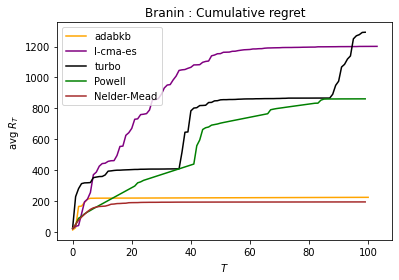

In [58]:

fig, ax = plt.subplots()
ax.set_title("Branin : Cumulative regret")
ax.plot(range(adabkb_regret.shape[0]), adabkb_regret, '-', color="orange", label="AdaBKB")
ax.plot(range(lcmaes_regret.shape[0]), lcmaes_regret, '-', color="purple", label="l-cma-es")
ax.plot(range(turbo_regret.shape[0]), turbo_regret, '-', color="black", label="TurBO")
ax.plot(range(powell_regret.shape[0]), powell_regret, '-', color="green", label="Powell")
ax.plot(range(nm_regret.shape[0]), nm_regret, '-', color="brown", label="Nelder-Mead")
ax.set_xlabel("$T$")
ax.set_ylabel("avg $R_T$")
ax.legend(loc="best")
